In [1]:
import os
import re
import json
import math
import time
import demoji
import curlify
import requests
import pandas as pd

import pickle
from scipy.special import softmax

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm.notebook import tqdm

all_stopwords = stopwords.words('english')
pd.set_option('display.max_colwidth', None)

bearer_token = "AAAAAAAAAAAAAAAAAAAAADSXjAEAAAAAQ32sCpTWcilVX%2BQj0BjOArOSYCE%3DUax6ZCizLRwwQcWQirExGQEDEB903dxBZKM4LAuGTMTvMa4jVP"

from datetime import date

today = date.today()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/crarojasca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SCRAP_CTTS = True
SCRAP_DENIALS = True

## Functions

In [3]:
s = requests.Session()
def getTweets(query, max_results=None, next_token=None):
    # Twitter Endpoint
    url = "https://api.twitter.com/2/tweets/search/recent"
    
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }
    
    # Query parameters
    params = {
        'query': query,
    #     'start_time': start_date,
    #     'end_time': end_date,
        'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
        'next_token': {}
    }
    if max_results: params['max_results'] = max_results
    if next_token: params['next_token'] = next_token

    try:
        time.sleep(6)
        req = requests.Request(
            "GET",
            url,
            params=params,
            headers=headers
        ).prepare()

        response = s.send(req)
        results = json.loads(response.text)
        return results
    except:
        print(json.loads(response.text))

def getUser(username):
    # User Endpoint 
    url = "https://api.twitter.com/2/users/by/username/" + username
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }

    params = {
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'next_token': {}
    }
    
    time.sleep(1)
    try:
        req = requests.Request(
            "GET",
            url,
            params=params,
            headers=headers
        ).prepare()

        response = s.send(req)
        results = json.loads(response.text)["data"]

        return json.loads(response.text)["data"]
    except:
        print(json.loads(response.text)["errors"][0]["detail"])


def count_tweets(query):
    # User Endpoint 
    url = "https://api.twitter.com/2/tweets/counts/recent"
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }

    params = {
        "query": query,
        "granularity": "day"
    }

    time.sleep(1)
    req = requests.Request(
        "GET",
        url,
        params=params,
        headers=headers
    ).prepare()

    response = s.send(req)
    results = json.loads(response.text)
    return results["meta"]["total_tweet_count"]
    
    
def extract_data(query, max_result=100):
    data = pd.DataFrame()

    # Scrap all the data up to the last page
    next_token = None

    n_tweets = count_tweets(query)
    if n_tweets==0:
        return data
    
    #
    pbar = tqdm(total=math.ceil(n_tweets/max_result))
    while True:
        pbar.update(1)
        try:
            results = getTweets(query=query, max_results=max_result, next_token=next_token)
            data = pd.concat([data, pd.DataFrame(results["data"])], ignore_index=True)
            if not "next_token" in results["meta"]:
                break
            next_token = results["meta"]["next_token"] 
        except:
            print(results)
            break
    pbar.close()
    
    # Reordering de columns
    columns = list(data.columns)
    columns.remove("text")
    columns.remove("public_metrics")
    data = data[["text", "public_metrics"] + columns]
    return data

def preprocess_text(text):
    # Lower
    preprocessed_text = text.lower()
    # Remove Handle
    preprocessed_text = re.sub("@\w+", "", preprocessed_text)
    # Remove Hashtag
    preprocessed_text = re.sub("#\w+", "", preprocessed_text)
    # Remove Links
    preprocessed_text = re.sub(r'http[s]?:\S+', '', preprocessed_text, flags=re.MULTILINE)
    # Remove emotes 
    preprocessed_text = demoji.replace(preprocessed_text, "")
    # Remove new line
    preprocessed_text = re.sub("\\n", "", preprocessed_text)
    # Remove extra spaces 
    preprocessed_text = preprocessed_text.strip()
    
    return preprocessed_text

def get_data(query):
    results = extract_data(query)
    results["preprocessed_text"] = results["text"].apply(preprocess_text)
    results = results.sort_values(by="created_at", ascending=False)
    results = results.drop_duplicates(subset=['text'], keep='last')
    results = results[(results.preprocessed_text!="")].copy(deep=True)
    return results

## ClimateScam
### Original Page

In [4]:
results = get_data("from:ClimateScam")
print(results.shape)
results[["preprocessed_text", "text", "public_metrics"]]

  0%|          | 0/1 [00:00<?, ?it/s]

(9, 12)


,preprocessed_text,text,public_metrics
0,"copenhagen researchers said in ""nature magazine"" that greenland's climates were much warmer 2 million years ago than today. they used dna proof from deceased animals and plants. so we live in an ice age &amp; the animals back then didn't. we won't burn up soon?! send $!","Copenhagen researchers said in ""Nature Magazine"" that Greenland's climates were much warmer 2 million years ago than today. They used DNA proof from deceased animals and plants. So we live in an ice age &amp; the animals back then didn't. We won't burn up soon?! Send $! #climatescam","{'retweet_count': 15, 'reply_count': 8, 'like_count': 45, 'quote_count': 1}"
1,"perfect comp info !! the doe believes they can bs the us public. the saddest part of this mess is they keep up the smoke &amp; mirrors &amp; tell each other how great they are. remember: 8 of the top 9 exec. positions at the doe have ""climate"" in their title.","@KingFredSports @climate_fact Perfect comp info @KingFredSports!! The DOE believes they can BS the US public. The saddest part of this mess is they keep up the smoke &amp; mirrors &amp; tell each other how great they are. Remember: 8 of the top 9 exec. positions at the DOE have ""Climate"" in their title. #climatescam","{'retweet_count': 1, 'reply_count': 1, 'like_count': 3, 'quote_count': 0}"
2,"the doe reports us evs “saved 690 million gas gals in 2021.” fossil fuels = 61% of usa's electricity. so less than 1/3 of that ""savings"" = fossil fuel reductions, or 230 million gals. the usa uses 370 million gals of gas/day… that’s not 2 days’ gas saved!! scam!!","The DOE reports US EVs “saved 690 million gas gals in 2021.” Fossil fuels = 61% of USA's electricity. So less than 1/3 of that ""savings"" = fossil fuel reductions, or 230 million gals. The USA uses 370 million gals of gas/day… that’s not 2 days’ gas saved!! SCAM!! #climatescam","{'retweet_count': 23, 'reply_count': 7, 'like_count': 61, 'quote_count': 2}"
3,"indonesia's mount semeru erupted sunday morning. the mayon volcano, the philippines' most active volcano, &amp; the bulusan volcano, 70 km from the mayon volcano, are smoking &amp; will blow. mauna loa, on hawaii's big island, blew last week. there goes the ""net zero"" bs!!","Indonesia's Mount Semeru erupted Sunday morning. The Mayon volcano, the Philippines' most active volcano, &amp; the Bulusan volcano, 70 km from the Mayon volcano, are smoking &amp; will blow. Mauna Loa, on Hawaii's Big Island, blew last week. There goes the ""Net Zero"" BS!! #climatescam","{'retweet_count': 31, 'reply_count': 8, 'like_count': 81, 'quote_count': 2}"
4,climatescamthebook.com,@macrospective climatescamthebook@gmail.com 👍,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"
5,"noaa's annual predictions: ""the 2022 atlantic hurricane season will be above normal,"" citing an ""ongoing la nina &amp; above average atlantic temps."" greenies: ""send more $, we're burning up!"" the season has ended, &amp; the 2022 season was below average in every category.","NOAA's annual predictions: ""the 2022 Atlantic hurricane season will be above normal,"" citing an ""ongoing La Nina &amp; above average Atlantic temps."" Greenies: ""send more $, we're burning up!"" The season has ended, &amp; the 2022 season was below average in every category. #climatescam","{'retweet_count': 46, 'reply_count': 4, 'like_count': 104, 'quote_count': 2}"
6,young humans are another target of the financial scam being masqueraded as a climate emergency.,Young humans are another target of the financial scam being masqueraded as a climate emergency. #ClimateScam https://t.co/Jri65Km5oQ,"{'retweet_count': 15, 'reply_count': 2, 'like_count': 87, 'quote_count': 1}"
8,"it's december &amp; ""renewables"" have problems: chinese solar-cell manufacturers avoided u.s. tariffs &amp; are shipping through southeast asia; they'll be cut off? probably not. germany has cold weather, low wind speeds, &amp; almost zero gas reserves. tri

### Complete lines

In [6]:
climate_scam_handle = get_data("@ClimateScam OR #ClimateScam OR from:ClimateScam -is:retweet")
print(climate_scam_handle.shape)
climate_scam_handle[["preprocessed_text", "text", "public_metrics"]].head()

  0%|          | 0/325 [00:00<?, ?it/s]

(10973, 14)


,preprocessed_text,text,public_metrics
0,rt : spot the climate crisis.,RT @tan123: Spot the climate crisis. #ClimateScam https://t.co/g1hflvmrkI,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"
2,spot the climate crisis.,Spot the climate crisis. #ClimateScam https://t.co/g1hflvmrkI,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}"
15,what a brainwashed fool. there is no only a !,@GBNEWS What a brainwashed fool. There is no #ClimateEmergency only a #ClimateScam !,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}"
17,"ask a leftist what percentage of earth's atmosphere is co². then appreciate the momentary silence (if they're capable of independent thought) when you tell them: ""0.04٪.""","Ask a Leftist what percentage of earth's atmosphere is CO². Then appreciate the momentary silence (if they're capable of independent thought) when you tell them: ""0.04٪."" #ClimateScam","{'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0}"
21,"rt : wow, that's great to hear you're getting through the crisis. what are some specific examples of how the cris…","RT @ULTRA_GARBO: @ClimatePower Wow, that's great to hear you're getting through the crisis. What are some specific examples of how the cris…","{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"


In [7]:
climate_scam_hashtag = get_data("#ClimateScam -is:retweet")
print(climate_scam_hashtag.shape)

  0%|          | 0/61 [00:00<?, ?it/s]

(4988, 14)


In [8]:
climate_scam_hashtag[["preprocessed_text", "text", "public_metrics"]].sample(5)

,preprocessed_text,text,public_metrics
4770,vote these useless things out!,#climatescam \n\nVote these useless things out! https://t.co/BexX8d6tBg,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"
3297,take what this clown says with a grain of salt he’s a wef puppet that wants to depopulate you,@haaretzcom Take what this clown @harari_yuval says with a grain of salt \n\nHe’s a WEF puppet that wants to depopulate you\n\n#ClimateScam #WEFpuppet,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"
4047,canadians being punished by a green globalist traitor for a tiny % of emissions.,Canadians being punished by a green globalist traitor for a tiny % of emissions. #ClimateScam https://t.co/ezl5mzgmMq,"{'retweet_count': 19, 'reply_count': 1, 'like_count': 22, 'quote_count': 0}"
3508,if only theyd take you our simon the porkypie man,@simonahac @abcnews if only theyd take you our Simon the PorkyPie man \n\n#ClimateScam https://t.co/VQj8p4fAQO,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"
5292,"i see the bots are out in force… because the oceans aren’t full of plastic and shit, the amazon isn’t on fire, the ice caps aren’t melting, pollution isn’t causing deaths, sea levels aren’t rising and wildlife hasn’t diminished by 70% in the last decade…oh!","I see the #ClimateScam bots are out in force… \n\nBecause the oceans aren’t full of plastic and shit, the Amazon isn’t on fire, the ice caps aren’t melting, pollution isn’t causing deaths, sea levels aren’t rising and wildlife hasn’t diminished by 70% in the last decade…oh! 🙄","{'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}"


In [9]:
def count_words(col):    
    df = col.str.split(expand=True).stack().value_counts().reset_index()
    df.columns = ['Word', 'Frequency'] 
    df = df[~df["Word"].str.lower().isin(all_stopwords)]
    return df

count_words(climate_scam_hashtag.text)[:30]

,Word,Frequency
0,#ClimateScam,4285
15,#TrudeauMustGo,671
16,climate,630
17,#agenda2030,617
18,lie,616
20,#WEFisEvil,608
21,try,607
22,#depopulation,591
23,link,588
24,#Nuremberg2,588


## CTTs
### Extracting
#### Users

In [10]:
ctts = pd.read_csv("CTTs/ctt_twitter_handles.csv")
ctts

,screen_name,Followers,Type,Name
0,capitalresearch,5023,CTT,Capital Research Center
1,ceidotorg,12565,CTT,Competitive Enterprise Institute
2,NationalCenter,7807,CTT,National Center for Public Policy Research
3,ReasonFdn,7030,CTT,Reason Foundation
4,ACSHorg,5734,CTT,American Council on Science and Health
5,AEI,151109,CTT,American Enterprise Institute
6,CatoInstitute,362920,CTT,CATO Institute
7,CFACT,13985,CTT,CFACT
8,FoF_Liberty,236,CTT,Frontiers of Freedom
9,FraserInstitute,31658,CTT,Fraser Institute


In [11]:
for i in range(ctts.shape[0]):
    username = ctts.loc[i].screen_name
    user_meta = getUser(username)
    ctts.loc[i, 'followers_count'] = user_meta['public_metrics']['followers_count']
    ctts.loc[i, 'following_count'] = user_meta['public_metrics']['following_count']
    ctts.loc[i, 'tweet_count'] = user_meta['public_metrics']['tweet_count']
    ctts.loc[i, 'listed_count'] = user_meta['public_metrics']['listed_count']
    ctts.loc[i, 'description'] = user_meta['description']
    ctts.loc[i, 'id'] = user_meta['id']
    ctts.loc[i, 'verified'] = user_meta['verified']
    ctts.loc[i, 'created_at'] = user_meta['created_at']
ctts

,screen_name,Followers,Type,Name,followers_count,following_count,tweet_count,listed_count,description,id,verified,created_at
0,capitalresearch,5023,CTT,Capital Research Center,5457.0,3069.0,8388.0,110.0,"Capital Research Center is America's Investigative Think Tank, covering all the influencers in our politics.",18957839,False,2009-01-13T23:07:06.000Z
1,ceidotorg,12565,CTT,Competitive Enterprise Institute,12828.0,3439.0,29967.0,588.0,"CEI is a non-profit public policy organization dedicated to advancing the principles of limited government, free enterprise, and individual liberty.",15471040,True,2008-07-17T17:49:08.000Z
2,NationalCenter,7807,CTT,National Center for Public Policy Research,7907.0,6292.0,23238.0,197.0,"The National Center for Public Policy Research is a nonpartisan, free-market conservative think-tank. Home of @Project21News & @FreeEntProject.",19384480,False,2009-01-23T06:38:46.000Z
3,ReasonFdn,7030,CTT,Reason Foundation,8625.0,97.0,6021.0,136.0,Reason Foundation is a nonprofit dedicated to advancing free minds and free markets. @ReasonFdn produces respected public policy research and publishes @reason.,1177334131732156420,True,2019-09-26T21:29:18.000Z
4,ACSHorg,5734,CTT,American Council on Science and Health,5958.0,570.0,4367.0,231.0,American Council on Science and Health. Science and consumer advocates since 1978. We separate facts from myths and debunk junk science.,195858764,True,2010-09-27T19:03:58.000Z
5,AEI,151109,CTT,American Enterprise Institute,160607.0,1393.0,67660.0,2936.0,Independent research driving the national conversation.,30864583,True,2009-04-13T13:33:33.000Z
6,CatoInstitute,362920,CTT,CATO Institute,366653.0,6996.0,96286.0,8482.0,"A public policy research organization dedicated to individual liberty, limited government, free markets, and peace.",15450996,True,2008-07-16T05:46:16.000Z
7,CFACT,13985,CTT,CFACT,14042.0,4481.0,11117.0,319.0,"CFACT defends the environment & human welfare through facts, news, and analysis, promoting free-market solutions to the world's environmental problems.",38532025,False,2009-05-07T22:20:56.000Z
8,FoF_Liberty,236,CTT,Frontiers of Freedom,296.0,523.0,2171.0,8.0,"Standing for Individual freedom, peace by strength, limited government, free markets, and traditional American values.",2464808161,False,2014-04-26T15:48:58.000Z
9,FraserInstitute,31658,CTT,Fraser Institute,32752.0,1102.0,15446.0,1050.0,#1 rated think tank in 🇨🇦! Improving the lives of Canadians with high-quality timely research and innovative outreach.,23529233,False,2009-03-10T00:18:34.000Z


In [12]:
## Total Tweets
ctts.tweet_count.sum()

681657.0

#### Tweets

In [13]:
handles_process = ctts.screen_name.unique()
    
total_sum = 0
for username in tqdm(handles_process):
    number = count_tweets("@{} -is:retweet".format(username))
    total_sum+=number
print("Number of tweets: {}".format(total_sum))
print("Aproximate time to process: {} minutes".format(total_sum*6/60/100))

  0%|          | 0/17 [00:00<?, ?it/s]

Number of tweets: 11824
Aproximate time to process: 11.824000000000002 minutes


In [14]:
if SCRAP_CTTS:
    file = "Twitter_scrapped/tweets_scrapped-CTTs_{}.csv".format(today)
    if os.path.isfile(file):
        tweets = pd.read_csv(file)
        handles_process = list(set(ctts.screen_name.unique()) - set(tweets.username.unique()))
    else:
        tweets = pd.DataFrame()
        handles_process = ctts.screen_name.unique()

    for username in tqdm(handles_process):
        handle_tweets = extract_data("@{} -is:retweet".format(username), 100)
        handle_tweets["username"] = username
        tweets = pd.concat([tweets, handle_tweets])
        tweets.to_csv("tweets_scrapped-CTTs.csv", index=False)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Preprocess

In [ ]:
file = "Twitter_scrapped/tweets_scrapped-CTTs_{}.csv".format(today)
tweets = pd.read_csv(file)

In [42]:
tweets.shape[0]

11787

In [43]:
tweets["preprocessed_text"] = tweets["text"].apply(preprocess_text)

In [44]:
real_tweets = tweets[tweets.referenced_tweets.isna() & (tweets.preprocessed_text!="")].copy(deep=True)
print("Number of tweets: {} from {} to {}.".format(
    real_tweets.shape[0],
    tweets.created_at.min(),
    tweets.created_at.max()
))

Number of tweets: 859 from 2022-11-28T12:31:21.000Z to 2022-12-05T12:14:19.000Z.


In [45]:
count_words(tweets.text)[:30]

,Word,Frequency
0,@Heritage,9144
24,people,729
25,@CatoInstitute,718
26,@KevinRobertsTX,692
28,@HudsonInstitute,643
31,@FreedomWorks,607
41,like,483
44,@SenatorLankford,445
45,get,429
47,@elonmusk,428


## Deniers
### Extracting
#### Users

In [7]:
denials = pd.read_csv("CTTs/denier_twitter_handles.csv")
for i in range(denials.shape[0]):
    username = denials.loc[i].screen_name
    user_meta = getUser(username)
    if not user_meta:
        continue
    denials.loc[i, 'exist'] = True
    denials.loc[i, 'followers_count'] = user_meta['public_metrics']['followers_count']
    denials.loc[i, 'following_count'] = user_meta['public_metrics']['following_count']
    denials.loc[i, 'tweet_count'] = user_meta['public_metrics']['tweet_count']
    denials.loc[i, 'listed_count'] = user_meta['public_metrics']['listed_count']
    denials.loc[i, 'description'] = user_meta['description']
    denials.loc[i, 'id'] = user_meta['id']
    denials.loc[i, 'verified'] = user_meta['verified']
    denials.loc[i, 'created_at'] = user_meta['created_at']
denials

User has been suspended: [PolitixGal].
User has been suspended: [Tony__Heller].
User has been suspended: [Piers_Corbyn].
User has been suspended: [PMgeezer].
User has been suspended: [Carbongate].
User has been suspended: [AusAntiLeft].
User has been suspended: [NikolovScience].
User has been suspended: [velardedaoiz2].
User has been suspended: [JWSpry].
User has been suspended: [JaggerMickOZ].
User has been suspended: [IceAgeFarmer].
Could not find user with username: [TimNBCBoston].
User has been suspended: [MooseMan1956].
User has been suspended: [Over400ppm].
User has been suspended: [ChrisJC12002].
User has been suspended: [OverTheMoonbat].
User has been suspended: [LearnFromNature].
User has been suspended: [AOECOIN].
User has been suspended: [SimonPearson961].
User has been suspended: [RuffusMD].
User has been suspended: [jenninemorgan].
User has been suspended: [2013Boodicca].
User has been suspended: [BrexitKite].
Could not find user with username: [RogerAPielkeSr].
User has b

,screen_name,Followers,Type,exist,followers_count,following_count,tweet_count,listed_count,description,id,verified,created_at
0,EcoSenseNow,107212.0,Climate Denier,True,130456.0,1416.0,48465.0,1131.0,"BSc Biology PhD Ecology, Greenpeace co-founder, Now a Sensible Environmentalist. Director https://t.co/lfVMUTLFbi. Science & logic, not sensation & fear. CelebrateCO2!",1392956425,False,2013-04-30T20:03:19.000Z
1,ShellenbergerMD,98407.0,Climate Denier,True,367560.0,748.0,22460.0,2573.0,"Pro-civilization : Time, ""Hero of the Environment"" : Bestselling author of ""Apocalypse Never"" & ""San Fransicko"" : Green Book Award : MD = my initials. Not a doc",2474749586,True,2014-05-03T01:10:35.000Z
2,RyanMaue,94377.0,Climate Denier,True,98721.0,4635.0,9242.0,3067.0,Extreme Weather and Climate | Meteorologist | Historian | Florida State PhD ⛱️☀️Michigan #GoBlue 🏈| Look Up 🚀 | 1908 Project for Prosperity 🦬,16117029,True,2008-09-03T18:27:32.000Z
3,PolitixGal,93040.0,Climate Denier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,catoletters,81717.0,Climate Denier,True,80997.0,27173.0,474777.0,883.0,"Voluntary Cooperation/Exchange; Human choice is the foundation of liberty. Read Rothbard and Mises. Peace NAP. End the Fed. Parody, I am not Cato The Younger",15063486,False,2008-06-09T18:11:35.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...
230,Apiglobal,3000.0,Climate Denier-Trade Assoc,True,3392.0,690.0,3279.0,90.0,API Global Industry Services (GIS) provides oil and gas professionals with resources necessary to advance safety and efficiency. @DieselMatters @MotorOilMatters,2885823443,False,2014-11-20T16:58:38.000Z
231,Chamberglobal,2263.0,Climate Denier-Trade Assoc,True,3101.0,199.0,3596.0,73.0,"The @USChamber's International Affairs Division advocates for free enterprise, competitive markets, and rules-based #trade and #investment.",1183621296,False,2013-02-15T19:55:20.000Z
232,NationalMining,1640.0,Climate Denier-Trade Assoc,True,2694.0,1780.0,4110.0,0.0,The National Mining Association (NMA) is the only national trade organization that serves as the voice of U.S. mining.,2422372057,False,2014-04-01T16:45:35.000Z
233,OfficialWSPA,1551.0,Climate Denier-Trade Assoc,True,1809.0,495.0,917.0,29.0,"Official account for the Western States Petroleum Association, dedicated to ensuring continued access to reliable, affordable and sustainable energy for all",615493717,False,2012-06-22T20:12:37.000Z


In [48]:
print("{} in total {}.".format((denials.exist==True).sum(), denials.shape[0]))

183 in total 235.


#### Tweets

In [49]:
handles_process = denials[denials.exist==True].screen_name.unique()
    
total_sum = 0
for username in tqdm(handles_process):
    number = count_tweets("from:{} -is:retweet".format(username))
    total_sum+=number
print("Number of tweets: {}".format(total_sum))
print("Aproximate time to process: {} minutes".format(total_sum*6/60/100))

  0%|          | 0/178 [00:00<?, ?it/s]

Number of tweets: 10597
Aproximate time to process: 10.597000000000001 minutes


In [50]:
denials_file = "Twitter_scrapped/deniers/{}.csv".format(today)
denials_to_process = denials[denials.exist==True]
if SCRAP_DENIALS:
    if os.path.isfile(denials_file):
        tweets_denials = pd.read_csv(denials_file)
        handles_process = list(
            set(denials_to_process.screen_name.unique()) - set(tweets_denials.username.unique()))
    else:
        tweets_denials = pd.DataFrame()
        handles_process = denials_to_process.screen_name.unique()

    for username in tqdm(handles_process):
        handle_tweets = extract_data("from:{} -is:retweet".format(username), 100)
        handle_tweets["username"] = username
        tweets_denials = pd.concat([tweets, handle_tweets])
        tweets_denials.to_csv(file, index=False)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
tweets_denials.sample(5)

,text,public_metrics,created_at,lang,source,reply_settings,id,edit_history_tweet_ids,conversation_id,author_id,in_reply_to_user_id,referenced_tweets,geo,username,roberta_preprocessed,roberta_pred,roberta_proba,preprocessed_text
3734,@Heritage https://t.co/j9bGsDm4SL,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-11-30T18:25:49.000Z,qme,Twitter Web App,everyone,1598020491096526848,[1598020491096526848],1597771547351322624,1551589711797522434,10168082,"[{'type': 'quoted', 'id': '1573074512597368833'}, {'type': 'replied_to', 'id': '1597771547351322624'}]",NaN,Heritage,@Heritage https://t.co/j9bGsDm4SL,0_0,0.999803,
123,What Americans Must Know About Socialism via @Heritage @LeeWEdwards https://t.co/bkhGUGJEyV,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-12-04T22:04:35.000Z,en,Twitter Web App,everyone,1599525096955138048,[1599525096955138048],1599525096955138048,1598117296559497216,NaN,NaN,NaN,Heritage,What Americans Must Know About Socialism via @Heritage @LeeWEdwards https://t.co/bkhGUGJEyV,0_0,0.999820,what americans must know about socialism via
7748,@Heritage https://t.co/nVWJXtMaO9,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-11-30T01:06:21.000Z,qme,Twitter Web App,everyone,1597758900195201024,[1597758900195201024],1597736519732580352,1230335584121450497,10168082,"[{'type': 'replied_to', 'id': '1597736519732580352'}]",NaN,Heritage,@Heritage https://t.co/nVWJXtMaO9,0_0,0.999797,
5113,@Heritage HAHAHAHA! GET F*CKED! https://t.co/oJAOLXcJ7s,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-11-30T06:31:23.000Z,tl,Twitter for Android,everyone,1597840699692810241,[1597840699692810241],1597734800848453633,1591157718160736273,10168082,"[{'type': 'replied_to', 'id': '1597736277868412928'}]",NaN,Heritage,@Heritage HAHAHAHA! GET F*CKED! https://t.co/oJAOLXcJ7s,0_0,0.999690,hahahaha! get f*cked!
4402,@971FMTalk @MarkReardonKFTK @Heritage @Tom_Basile @ChiefTimFitch @JimTalent @TommyPigott @susan6768 @hobold_abby Trump 2024.,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-11-30T14:39:14.000Z,en,Twitter for Android,everyone,1597963469089017862,[1597963469089017862],1597698244196601857,2537478487,38711343,"[{'type': 'replied_to', 'id': '1597698244196601857'}]",NaN,Heritage,@971FMTalk @MarkReardonKFTK @Heritage @Tom Basile @ChiefTimFitch @JimTalent @TommyPigott @susan6768 @hobold abby Trump 2024.,0_0,0.999780,trump 2024.


## Model
### #ClimateScam

In [16]:
import unicodedata

# Load and pre-process the text data
# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()


# Pre-process the text
climate_scam_hashtag['roberta_preprocessed'] = climate_scam_hashtag["text"].astype(str).apply(denoise_text)

In [17]:
import torch
from simpletransformers.classification import ClassificationModel

device = torch.device("cpu")
# Define the model 
architecture = 'roberta'
# model_name = 'CARDS_RoBERTa_Classifier'
model_name = "cards/models/CARDS_RoBERTa_Classifier"

# Load the classifier
roberta_model = ClassificationModel(architecture, model_name, use_cuda=False)

Some weights of the model checkpoint at cards/models/CARDS_RoBERTa_Classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
predictions, raw_outputs = roberta_model.predict(list(climate_scam_hashtag.roberta_preprocessed))

  0%|          | 0/4988 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

In [19]:
le = pickle.load(open("le_cards.pkl", 'rb'))

In [20]:
climate_scam_hashtag['roberta_pred'] = le.inverse_transform(predictions)
climate_scam_hashtag['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [21]:
climate_scam_hashtag.roberta_pred.value_counts().to_frame().head()

,roberta_pred
5_2,3260
0_0,1360
4_1,128
2_3,79
4_4,51


<AxesSubplot:>

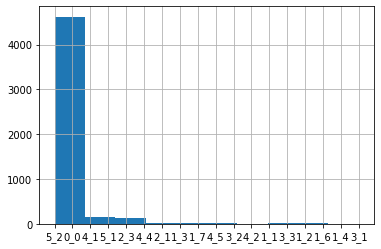

In [22]:
climate_scam_hashtag.roberta_pred.hist()

In [23]:
climate_scam_hashtag[["text", "roberta_pred", "roberta_proba"]]

,text,roberta_pred,roberta_proba
0,#ClimateCrisis #ClimateEmergency #climate #ClimateScam are you watching this? https://t.co/qyYkzXW1ne,5_2,0.998873
1,@juneslater17 You know what it was about\n#TheGreatReset \n#ClimateScam,5_2,0.960789
2,"Can’t you see that it’s not about the climate, it’s all about CONTROL!\n\n#ClimateScam https://t.co/hDniM33v58",5_2,0.999329
3,"FUUUUUU-UUUUU-CCCCCCKKKK YOU!!\n\nVehemently. ZERO KILOS of beef per person per year???? You Elitists truly want to be bloody slaughtered, don't you? I remind you of the French Revolution. How did that go?\n\n#ClimateScam #KlausSchwab #BillGates #WEFisEvil #AbolishTheUN #WHO #NWO https://t.co/3mWfGkn0FE",5_2,0.993764
4,@DavidShoebridge Hopefully they lose the key. #ClimateScam #ClimateAlarmism,5_2,0.999489
...,...,...,...
6022,@SpursOfficial Greenwashing crap #ClimateScam,5_2,0.999228
6023,"@MayorofLondon @wef So, does this mean you are a WEF puppet, who owes your primary allegiance to unelected globalists? \n\nis this why you are forcing terrible Net Zero policies on Londoners and making us all poorer? \n\nThere really is no #NoClimateEmergency ... #ClimateScam",5_2,0.998349
6025,"Today is November 28, 2022 and @JustinTrudeau is the WORST \nPrime Minister in #Canadian History \n#TrudeauMustGo #TrudeauResign #justinflation #ClimateScam #CarbontaxBS #trudeaucarbonfootprint",5_2,0.737636
6027,@RDTVF Donate @RDTVF #internetradio supporting all genres unsigned indie music playing #Death by #Plastic by UK rock outfit The #Crime Scene Cleaners @SceneCleaners #ClimateCrisis #ClimateScam #COP27 #ecology #WeatherUpdate #green #JustStopOil\ncheck their music\nhttps://t.co/psU7oPSah7,0_0,0.982992


In [24]:
climate_scam_hashtag.loc[
    climate_scam_hashtag.roberta_pred=="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(10)

,text,roberta_pred,roberta_proba
833,"@robertalives my link is ""safe"" but they lie and try to censor bitchute\nhttps://t.co/exZczwti4C\n#PandemicAmnesty\n#CrimesAgainstHumanity\n#DiedSuddenly\n#Myocarditis\n#TruthAboutMRNAVaccines \n#depopulation\n#agenda2030\n#Nuremberg2\n#Pfizergate\n#WEFisEvil\n#ClimateScam\n#TrudeauMustGo\n#StoptheShots",0_0,0.985691
1365,"@ejwwest @adamvaughan_uk @Peradventur3 @elonmusk @MelissaFleming @KHayhoe Wow, 4 people out of your 3,000 bot followers to like your tweet? #LOL WEAK. #ClimateScam",0_0,0.872358
562,"Is everyone who takes a contrarian view on climate change, by default, ""right wing""?\n\nThe girls at the Guardian seem to think so.\n\nThey'd be excellent staff for loading up ""right wingers"" onto the trains for the camps I think.\n#climatescam\nhttps://t.co/wgAGTbwJth https://t.co/4nhMGcOWuI",0_0,0.998571
4185,@AFP Rubbish. Who is looking for money in this situation? #climatescam,0_0,0.999779
3142,"and that number is about to go lower...much, much lower...\n\n#firefauci\n#neverforgetthesepeople\n#ClimateScam\n#jimcramer\n#endthefed\n#endthemandates\n#trudeaumustgo https://t.co/SH8yphllVX",0_0,0.915858
1759,The latest The Cork Environment Daily! https://t.co/pBtPcSHFwa Thanks to @globalactplan #climatescam,0_0,0.999797
2767,"@TruthFreedomPe1 my link is ""safe"" but they lie and try to censor bitchute\nhttps://t.co/9xVv5rAqbf\n#PandemicAmnesty\n#CrimesAgainstHumanity\n#DiedSuddenly\n#Myocarditis\n#TruthAboutMRNAVaccines \n#depopulation\n#agenda2030\n#Nuremberg2\n#Pfizergate\n#WEFisEvil\n#ClimateScam\n#TrudeauMustGo\n#StoptheShots",0_0,0.982245
4756,#FIFAWorldCupQatar2022 #USAvIRN #antony #Biden Democrats #Brazil Chrismas #ChinaProtests #ClimateScam \n#GOT7Win2022MAMA \n#GujaratAssemblyPolls \n#khargeinkarnataka \n#UkraineRussiaWar \n#kashmirfilesmovie schindler nuclear https://t.co/iJUl3OCQLA,0_0,0.999643
2337,@Greenpeace Meanwhile the kids are faced with HUNDREDS of climate questions as described in the IPCC AR4 AR5 and AR6...\n\nThey are sure of NOTHING! \n\nEven the most basic questions need answers BEFORE STEALING their futures by this generation!\n\n#climate #ClimateActionNow #climatescam #co2day https://t.co/8NfU7ISkB7,0_0,0.996956
4505,New Climate News: \n\nDifferences in character between red knots seem to be an important ingredient for the resilience of the whole group -- ScienceDaily\n\n#climatecrisis #climateaction #esg #carbon #sustainability #netzero #climatescam #globalwarming #c...\nhttps://t.co/7KMZuSbHDx,0_0,0.999556


In [25]:
results['roberta_preprocessed'] = results["text"].astype(str).apply(denoise_text)
predictions, raw_outputs = roberta_model.predict(list(results.roberta_preprocessed))
results['roberta_pred'] = le.inverse_transform(predictions)
results['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
results[["text", "roberta_pred", "roberta_proba"]]

,text,roberta_pred,roberta_proba
0,Young humans are another target of the financial scam being masqueraded as a climate emergency. #ClimateScam https://t.co/Jri65Km5oQ,5_2,0.999402
2,"It's December &amp; ""renewables"" have problems: Chinese solar-cell manufacturers avoided U.S. tariffs &amp; are shipping through Southeast Asia; they'll be cut off? Probably not. Germany has cold weather, low wind speeds, &amp; almost zero gas reserves. Tripling energy prices! #climatescam",0_0,0.989353
3,"Many of the so-called ""climate scientists"" ringing the disaster bell don't even let other scientists review their work. Why is that? We keep discovering they are making up data. Too much money is at stake for them to tell the truth that there is no climate crisis. #ClimateScam https://t.co/Atkq3WKiwi",5_2,0.999495
4,"@GeraldKutney Please, share your peer reviewed, scientific research for this claim. Or how about your unconfirmed reports? Who made those? We are waiting. To even suggest that humans can control the earth and weather is the most audacious claim. #ClimateScam",5_2,0.999468
5,"@guardianeco This article is a perfect illustration of the truly amazing fear campaign the climate folks have created. The second anyone tries to get the truth out there, the minions surround the truth &amp; scream denialism. NO ONE IS DENYING CLIMATE CHANGES.",5_2,0.999332
6,@FrankRipainter @MatthewWielicki Very similiar fear campaign. They got the road map from COVID now they will utilize that with climate if we do not try to stop it. Time to get the truth out there. #climatescam,5_2,0.997548
7,"RT @MatthewWielicki: I lied, one last slide (maybe) from my climate lecture this week. I have a hard time figuring out why having young peo…",0_0,0.999742
8,"Note: ""leaving out key details to be worked out later."" #ClimateScam https://t.co/9cx7bJzlQs",5_2,0.998120
9,"Greenland's ice sheet's surface mass balance (SMB) is at one of its highest levels since 1981 &amp; increasing this winter. Greenland has consistent growth SMB since 2016. Worldwide, this year's start to winter is the coldest since 1982. When does the world burn up? FYI. #climatescam",1_1,0.976762
10,"@MatthewWielicki Its terrible what they are doing to the youth of the world. Thank you for being out there, educating them on the truth. #climatescam",0_0,0.999717


In [27]:
file = "Twitter_scrapped/@ClimateScam_CARDS_predictions_{}.csv".format(today)
climate_scam_hashtag.to_csv(file)

### CTTs

In [28]:
tweets['roberta_preprocessed'] = tweets["text"].astype(str).apply(denoise_text)

In [29]:
predictions, raw_outputs = roberta_model.predict(list(tweets.roberta_preprocessed))

  0%|          | 0/11787 [00:00<?, ?it/s]

  0%|          | 0/1476 [00:00<?, ?it/s]

In [30]:
tweets['roberta_pred'] = le.inverse_transform(predictions)
tweets['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [46]:
# tweets = pd.read_csv("@Twitter_CTTs_predictions.csv")
tweets.roberta_pred.value_counts().to_frame().head()

,roberta_pred
0_0,11712
5_2,65
4_1,7
4_4,2
5_1,1


In [32]:
tweets[tweets.referenced_tweets.isna()].shape

(873, 17)

<AxesSubplot:>

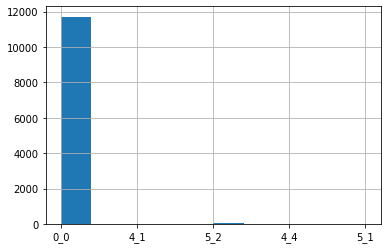

In [33]:
tweets.roberta_pred.hist()

In [34]:
tweets[["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
8918,@Heritage @SamuelBrownback @DailySignal CBDC is why they don't care how large the debt gets... It is all going to be RESET... Plus the CBDC is an end run around the constitution... Note to businesses... CLICK and your out of business... This is terrifying...,0_0,0.999080
1934,@Heritage Also it's kind of weird how nobody has looked into how much commercial real estate other countries own in America how much Farmland other countries own in America and how they're going to use the Farmland to get the mineral rights to start mining for coal in America for China,0_0,0.999765
1536,@ExposingBiden @Heritage @SenWhitehouse Throw his ass in jail. He belongs there more than the j6ers,0_0,0.999571
3345,@ladyjoymoving @Heritage You think he intended for you to be hateful ?,0_0,0.999735
91,@FreedomWorks Just imagine spending this many years in our US government and still not understanding how it works.,0_0,0.999729


In [35]:
tweets.loc[tweets.roberta_pred!="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
103,@NileGardiner @Heritage Here is a test you guys must answer before you can have input anymore—- who was the president in oct 2020 when the trump White House asked twitter to remove / censor tweets. And twitter complied??? Can you answer??? No cheating lol. Hypocrites,5_2,0.986456
292,@Heritage @DFR_Economics China and India are not developing countries it’s just a scam,5_2,0.971350
402,"@FreedomWorks Is this like “ we just put together the greatest fraud election plan on planet earth” ?…. You Lyin Joe Biden with Beijing tendencies are the biggest gas bag on earth, rotten to the core!! 🤮",5_2,0.998705
7900,"@GaryWatling3 @KevinRobertsTX @redrivergrl @Heritage Exactly!! Obviously there are so many sick perverts with jobs that they shouldn’t have (sniffy Joe, Pelosi because of helping cover up her husbands threesome sex party and all of those involved with Jeffrey Epstein…an obvious murder cover up!) and their money buys it all!",5_2,0.991079
833,"@Heritage @jordanbpeterson @elonmusk Dr. Peterson, I would be interested to hear from you anything about cognitive dissonance regarding this now absolutely clear evidence of fraud and the left’s continued denial of anything wrong.",5_2,0.998097


In [36]:
file_CTT = "Twitter_scrapped/@Twitter_CTTs_predictions_{}.csv".format(today)
tweets.to_csv(file_CTT)

In [27]:
# samples = (
#     tweets.groupby("roberta_pred")
#     .sample(10, replace=True)[["text", "roberta_pred", "roberta_proba"]]
#     .drop_duplicates("text")
# )
# samples.to_csv("@Twitter_CTTs_predictions_samples.csv")

### Denials

In [52]:
tweets_denials['roberta_preprocessed'] = tweets_denials["text"].astype(str).apply(denoise_text)
predictions, raw_outputs = roberta_model.predict(list(tweets_denials.roberta_preprocessed))

  0%|          | 0/11787 [00:00<?, ?it/s]

  0%|          | 0/1476 [00:00<?, ?it/s]

In [53]:
tweets_denials['roberta_pred'] = le.inverse_transform(predictions)
tweets_denials['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [12]:
# tweets_denials = pd.read_csv("@Twitter_Denials_predictions.csv")

In [54]:
tweets_denials.roberta_pred.value_counts().to_frame().head()

,roberta_pred
0_0,11712
5_2,65
4_1,7
4_4,2
5_1,1


<AxesSubplot:>

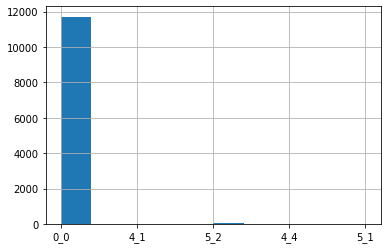

In [55]:
tweets_denials.roberta_pred.hist()

In [56]:
tweets_denials[["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
457,@CatoInstitute @CatoHealth @dr4liberty Ryan White was unavailable for comment.,0_0,0.999761
8514,@denhaag180 @PM_ViktorOrban @Heritage @KevinRobertsTX I wish he was your president too and not ours.,0_0,0.999783
59,"""For cops and prosecutors to do their jobs effectively, their motives must be beyond suspicion. But looking at the effect of civil forfeiture on law enforcement, this prosecutor’s firsthand experience suggests that we’re not there yet.""\n\nhttps://t.co/Q28LVbbJWl\n@ceidotorg",0_0,0.999830
368,"@RepThomasMassie @Heritage @POTUS Ppl r being condemned on all sides of the #Covid19 narrative BUT where does the TRUTH lie among ALL these varying narratives, whether the narrative is from the average person or a world renowned scientist? Who is the decider of what is fact/fiction/information/misinformation?",0_0,0.999529
2416,You &amp; @GOP @SenateGOP @HouseGOP bought it @mikepompeo … you broke it … #TrumpCrimeFamily is your #FrankensteinMonster \n\nFVCKing #CHOKEonTHAT \n\n@foxnews @oann @RSBNetwork @newsmax @infowars @unite1st @BenBergquam @charliekirk11 @tpusa @frcdc @March_for_Life @FedSoc @Heritage https://t.co/GLHKcudQMu,0_0,0.999787


In [57]:
tweets_denials.loc[tweets_denials.roberta_pred!="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
8987,@Heritage What about the inflation reduction act. We all know that’s a fucking scam.,5_2,0.999149
103,@NileGardiner @Heritage Here is a test you guys must answer before you can have input anymore—- who was the president in oct 2020 when the trump White House asked twitter to remove / censor tweets. And twitter complied??? Can you answer??? No cheating lol. Hypocrites,5_2,0.986456
4,"@jenna_redux @FriendsOScience @myview1872 @CoryBMorgan @dlee_ann True science is “never” settled. That’s what makes it science. Climate “science” is fraudulent, wrong, and corrupted; scientific integrity has been sacrificed on the altar of political agenda. #corruptedscience #fraudulentscience #ClimateScam @jordanbpeterson @PeterDClack @CFACT",5_2,0.999487
5,My @ceidotorg colleague @Mario_A_Loyola brings some bracing realism to the climate change debate:\nClimate Policies Not Based on Market Principles Will Fail\nhttps://t.co/6aOddI87y5,4_1,0.637364
51,@davidrvetter @tan123 @HeartlandInst FALSE DAVE... \n#DaveTheClimateScammer,5_2,0.998494


In [58]:
file_denials = "Twitter_scrapped/@Twitter_Denials_predictions_{}.csv".format(today)
tweets_denials.to_csv(file_denials)

In [28]:
samples = (
    tweets_denials.groupby("roberta_pred")
    .sample(10, replace=True)[["text", "roberta_pred", "roberta_proba"]]
    .drop_duplicates("text")
)
samples.to_csv("@Twitter_Denials_predictions_samples.csv")